In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [3]:
# load runs from experiments
experiments = []
experiments += ['jul19', 'sep1']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 870 runs


In [ ]:
def make_combo_specific(evaluation):
    r = dict()
    for k,v in evaluation.samples.items():
        if isinstance(v, dict):
            for k2, v2 in v.items():
                r[f'{k}_{k2}'] = v2
        else:
            r[k] = v
    del r['rewards']

    c_df = pd.DataFrame(r)
    type_columns = [c for c in c_df if 'types_' in c]
    c_df['combo'] = list(map(tuple, c_df[type_columns].values))
    mean_lengths = c_df.groupby('combo')['auction_lengths'].mean()
    ### A given type combo where tie-breaking (non-final) seems to matter
    for v in mean_lengths.values:
        if not v.is_integer() and v < 4:
            print("FOUND YOU", v)
            return True
    return False


In [ ]:
records = []

for run in tqdm(runs):
    try:
        checkpoints =  run.equilibriumsolverruncheckpoint_set.all()
        if len(checkpoints) == 0:
            print(f"No checkpoints for {run}!")
            
        for e in checkpoints.all():
            evaluation = e.get_modal_eval()
            record = dict(run=run.name, game=run.game.name, t=e.t, modal_nash_conv=evaluation.nash_conv, walltime=e.walltime, alg=get_algorithm_from_run(run), rewards=evaluation.mean_rewards, improvements=evaluation.player_improvements)

            x = dict(run.config)
            # del x['seed']
            del x['use_wandb']
            del x['solver_type']
            record.update(x)


        ### For Greg: convergence test
#             if run.config['seed'] != 100:
#                 continue
#             try:
#                 game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False, load_policy=True)
#             except Exception as e:
#                 print(f"Skipping run {run.name} because of error {e}")
#                 continue

#             total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test
#             record['total_entropy'] = total_entropy
        ### End


            records.append(record)
    except Exception as e:
        print(f"Run {run} facing error {e}")
        continue

In [ ]:
df_time = pd.DataFrame.from_records(records)
# df_time['variant'] = list(map(str,(zip(df_time.sampling_method, df_time.linear_averaging, df_time.regret_matching_plus, df_time.explore_prob, df_time.tremble_prob, df_time.regret_init, df_time.regret_init_strength))))
df_time['variant'] = list(map(str,(zip(df_time.sampling_method, df_time.linear_averaging, df_time.regret_matching_plus))))#, df_time.explore_prob, df_time.tremble_prob, df_time.regret_init, df_time.regret_init_strength))))

In [ ]:
df_time['modal_nash_conv'].describe()

In [ ]:
# plt.figure(figsize=(9,9))

# # Does longer = better?
# dt = df_time.query('~modal_nash_conv.isnull()')
# dt = dt.groupby('variant').filter(lambda grp: len(grp) > 25)
# dt = dt.query('seed == 100 and t > 1_000')
# dt['port'] = dt['run'].str.contains('port')
# # TODO: Limit to same comparison
# dt = dt.groupby(['game', 'variant']).filter(lambda grp: len(grp) == 2)
# # dt.groupby(['variant', 'port'])['modal_nash_conv'].describe()
# dt.pivot(values=['modal_nash_conv'], columns=['port'], index=['variant', 'game']).plot(kind='scatter', x=("modal_nash_conv", False), y=("modal_nash_conv", True))
# plt.axline((0, 0), slope=1)

# # dt.groupby(['variant', 'game'])['modal_nash_conv']

In [ ]:
# df_time.groupby(['sampling_method', 'linear_averaging', 'regret_matching_plus', 'explore_prob'])['modal_nash_conv'].mean()
# Why are 25 rows missing?

# df_time.pivot(['sampling_method', 'linear_averaging', 'regret_matching_plus', 'explore_prob'], index='run', values='modal_nash_conv')


In [ ]:
df_time.query("""variant == "('outcome', True, True, nan, nan, 'straightforward_clock', 100.0)" and t > 1000""")['modal_nash_conv'].describe()

In [ ]:
df_time.groupby('game').size()

In [ ]:
num_variants = df_time['variant'].nunique()
df_all = df_time.groupby('game').filter(lambda grp: len(grp) == 9 and grp['modal_nash_conv'].isnull().sum() == 0) # Only look at games where ALL of them had runs and everyone finished NashConv calcs for fairness


In [ ]:
df_all.groupby(['variant'])['modal_nash_conv'].describe().sort_values('mean')

In [ ]:
#### PORTFOLIO LOGIC ####
portfolio = []
algs = df_time['variant'].unique()
df_port = df_all[['variant', 'game', 'modal_nash_conv']].rename(columns={'variant': 'alg', 'game': 'instance', 'modal_nash_conv': 'runtime'})

# Greedy portfolio agg
for i in range(5):
    alg2score = dict()
    for alg in algs:
        new_port = portfolio + [alg]
        score = df_port.query('alg in @new_port').groupby('instance')['runtime'].min().sum()
        alg2score[alg] = score

    best_alg = pd.Series(alg2score).sort_values().idxmin()
    best_score = pd.Series(alg2score).sort_values().min()
    print(i, best_alg, best_score)
    portfolio.append(best_alg)



In [ ]:
df_heatmap = df_all[['variant', 'modal_nash_conv', 'game']].pivot_table(
    values='modal_nash_conv',
    columns=['game'],
    index='variant'
)
df_heatmap_norm=(df_heatmap / df_heatmap.max())
sns.heatmap(df_heatmap_norm, annot=True, cmap='Blues')

In [ ]:
df_all[['variant', 'modal_nash_conv', 'game']].pivot_table

In [ ]:
z = df_all.query(""" variant == "('outcome', True, True, 0.4)" """)
(z['modal_nash_conv'] / z['rewards'].apply(sum))

In [ ]:
df_time['reward_sum'] = df_time['rewards'].apply(lambda x: sum(x))
df_time['nash_conv_frac'] = df_time['modal_nash_conv'] / df_time['reward_sum']

In [ ]:
df_time.loc[df_time.groupby('run')['t'].idxmax()]

In [ ]:
# TODO: I only want the LAST nashconv, this is dumb
# df.query('~modal_nash_conv.isnull() and alg == "cfr_outcome"').groupby('run')['modal_nash_conv'].describe().sort_values('mean', ascending=False).head(20)

In [ ]:
df.loc[df.groupby('run')['t'].idxmax()].set_index('run')['nash_conv_frac'].sort_values(ascending=False).describe() # Why 69 and not 75?
# In summary, NashConv is usually less than 10%. Hopefully this is also true on a per-player basis. There are a 13 bad cases with > 10%, 7 NaN, and 49 "good"

In [ ]:
# What if you took the "best" t? Can get up to 53 that way... 
(df.groupby('run')['nash_conv_frac'].min() < 0.1).sum()

In [ ]:
plt.figure(figsize=(16, 9))
plt_df = df_time.query('~modal_nash_conv.isnull()').groupby('run').filter(lambda grp: len(grp) > 1).sort_values('t')
for r, sub_df in plt_df.groupby('run'):
    # display(sub_df)
    plt.plot(sub_df['walltime'].values, sub_df['modal_nash_conv'].values, alpha=0.2, color='grey')
plt.ylabel("modal nash conv")
plt.xlabel("walltime")
# plt.legend()
plt.semilogy()
# sns.lineplot(data=plt_df, y='modal_nash_conv', x='t', hue='run', legend=False)

# How many lines are changing downwards? Why is almost no progress ever made after 500K iterations?


In [ ]:
# A different question: What is sum(nash_conv) over walltime? Would have to be careful because of missing data though... Try to quantify improvement of moving to each new update
# Or else a CDF or something of when somethign EVER discovers a good checkpoint, grouped by alg?
# Basically want to know how much time is useful. Sad we didn't run a 0.1 explore to see if that fared better... Maybe look at each alg indepdently?

In [ ]:
plt_df['run'].values

In [ ]:
deltas = df.loc[df.groupby('run')['t'].idxmin()].set_index('run')['modal_nash_conv'] - df.loc[df.groupby('run')['t'].idxmax()].set_index('run')['modal_nash_conv']
deltas[deltas > 0]
# Most of the time, the deltas are very weakly positive. Can definitely move in either direction

In [ ]:
len(e.get_model()._infostates)

In [ ]:
dir(e)

# Analyze runs

In [4]:
# empirical = True
# USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=True, load_policy=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

#         if USE_MODAL:
#             evaluation = final_checkpoint.get_modal_eval()
#             # if make_combo_specific(evaluation):
#             #     print(run.name)
#         else:
#             evaluation = final_checkpoint.get_old_eval()
            
            
        # total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test

        # if empirical: 
        #     history_dists = empirical_history_distribution(final_checkpoint.get_old_eval()) # Always use the old eval here
        #     history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
        # else:
        #     history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        #     history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

        # try:
        #     # TODO: Broken until you remove "Tremble" agents
        #     _, _, approx_nash_conv = find_best_checkpoint(run)
        # except:
        #     # TODO: Fix bug where this actually happens because your BRs failed to do better and you have an Empirical Nash Conv of 0, very different from NaN
        #     # ev_df = parse_run(run, None)
        #     # display(ev_df)
        #     approx_nash_conv = np.nan

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'activity_policy': ActivityPolicy(game.auction_params.activity_policy).name,
            'undersell_policy': UndersellPolicy(game.auction_params.undersell_policy).name,
            'tiebreaking_policy': TiebreakingPolicy(game.auction_params.tiebreaking_policy).name,
            'grace_rounds': game.auction_params.grace_rounds,
            'risk_aversion': 'risk' in run.game.name, # TODO: actually read this from players
            'spite': 'spite' in run.game.name, # TODO: actually read this from players
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # metrics from eval
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        evaluation = final_checkpoint.get_modal_eval()
        # evaluation = final_checkpoint.get_old_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan
        
        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan
        
            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan
          
        record.update(**analyze_samples(evaluation.samples, game))

        # Slowwwwww you may want to comment this out when not using it
#         start = time.time()
        # c = final_checkpoint.equilibrium_solver_run.config
        # env_and_policy = ppo_db_checkpoint_loader(final_checkpoint)
        # for player in range(game.num_players()):
        #     env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
        # modal_policy = env_and_policy.make_policy()
        
        # worked, time_taken, hc = time_bounded_run(15, nash_conv, game, modal_policy, restrict_to_heuristics=True)
        # if not worked:
        #     print("Aborted run because time")
        # record['heuristic_conv'] = hc if worked else np.nan
        # record['heuristic_conv_time'] = time_taken
#         print(time.time() - start)

        records.append(record)
    
        nc = record['nash_conv']
        hc = record['heuristic_conv']
        # print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

 42%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 365/870 [01:57<01:49,  4.61it/s]

Something wrong with aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg-101 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 370/870 [01:58<01:16,  6.54it/s]

Something wrong with aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-101 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 413/870 [02:06<02:12,  3.44it/s]

Something wrong with aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-100 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 547/870 [02:38<01:09,  4.64it/s]

Something wrong with aug31_aug31_0_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-100 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 554/870 [02:39<01:04,  4.91it/s]

Something wrong with aug31_aug31_0_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-101 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 562/870 [02:41<01:32,  3.34it/s]

Something wrong with aug31_aug31_0_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-102 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 615/870 [02:54<01:15,  3.37it/s]

Something wrong with aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg-100 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 622/870 [02:56<01:07,  3.70it/s]

Something wrong with aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-102 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 850/870 [03:52<00:02,  7.08it/s]

Something wrong with jun26_jun26_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg-101 (sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9055/2130560204.py", line 73, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 870/870 [03:56<00:00,  3.68it/s]

861


In [5]:
df = pd.DataFrame.from_records(records)
# df['imperfect'] = df['game_name'].str.contains('imperfect')


In [18]:
(df['heuristic_conv'] / df['nash_conv']).mean()

0.5858309480012677

In [19]:
df['rule_set'] = df.apply(lambda row: row.game_name.split(row.base_game_name)[1][1:-5], axis=1)

In [20]:
def describe_nc(df):
    print("NC")
    print(df['nash_conv'].describe())
    
    print("HC when NC is not null")
    print(df.query('~nash_conv.isnull()')['heuristic_conv'].describe())
    
    print("HC when NC is null")
    print(df.query('nash_conv.isnull()')['heuristic_conv'].describe())
    
    print("HC overall")
    print(df['heuristic_conv'].describe())
    print()
    
    


# Overall
print("OVERALL")
describe_nc(df)

# Did biasing towards heuristics help?
no_bias = df.query('config.str.contains("cfr_port_2_no_ext")')
print("NO BIAS")
describe_nc(no_bias)

yes_bias = df.query('config.str.contains("cfr_port_3")')
print("YES BIAS")
describe_nc(yes_bias)


OVERALL
NC
count    744.000000
mean       5.371278
std        8.203513
min        0.000000
25%        0.200500
50%        2.138427
75%        6.854778
max       60.045099
Name: nash_conv, dtype: float64
HC when NC is not null
count    744.000000
mean       3.002718
std        5.452748
min        0.000000
25%        0.055769
50%        0.594393
75%        3.665513
max       46.346408
Name: heuristic_conv, dtype: float64
HC when NC is null
count    117.000000
mean       7.408617
std       10.618296
min        0.000000
25%        0.125513
50%        3.329372
75%        9.651012
max       63.427289
Name: heuristic_conv, dtype: float64
HC overall
count    861.000000
mean       3.601429
std        6.570953
min        0.000000
25%        0.059670
50%        0.767510
75%        4.334753
max       63.427289
Name: heuristic_conv, dtype: float64

NO BIAS
NC
count    624.000000
mean       5.551045
std        8.422937
min        0.000000
25%        0.190093
50%        2.297282
75%        7.412259
m

In [ ]:
df.heuristic_conv.describe()

In [ ]:
plt.scatter(
    df.nash_conv.values,
    df.heuristic_conv.values,
    s=2
)
plt.xlabel('NashConv')
plt.ylabel('HeuristicConv')

In [ ]:
df['DifferenceConv'] = df.nash_conv - df.heuristic_conv
df.sort_values('DifferenceConv').dropna().tail().run_name.values

In [ ]:
df.sort_values('heuristic_conv').dropna().tail().run_name.values

In [ ]:
df.query('~nash_conv.isnull()').variant.value_counts()

In [ ]:
df.query('~heuristic_conv.isnull()').variant.value_counts()

In [ ]:
df.query('nash_conv.isnull()').variant.value_counts()

In [29]:
# TODO: Maybe actually make this readable?
df['variant'] = list(map(str,(zip(df.information_policy, df.clock_speed, df.activity_policy, df.undersell_policy, df.tiebreaking_policy, df.risk_aversion, df.grace_rounds))))
palette = dict()

colors = ['red', 'blue', 'magenta', 'green', 'orange', 'brown', 'black', 'navy', 'pink', 'gold', 'darkgreen', 'orangered', 'olive']

for i, v in enumerate(df['variant'].unique()):
    palette[v] = colors[i]

In [63]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df.copy()

In [59]:
### Remove bad entries
good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}')
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)

# (df.groupby('game_name').size() - df_plt.groupby('game_name').size()).sort_values()

(861, 679)

In [60]:
# df.query('activity_policy == "OFF"')['nash_conv_frac']
# df.query('undersell_policy == "UNDERSELL" and information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 ')[['t', 'nash_conv', 'nash_conv_frac']]

279


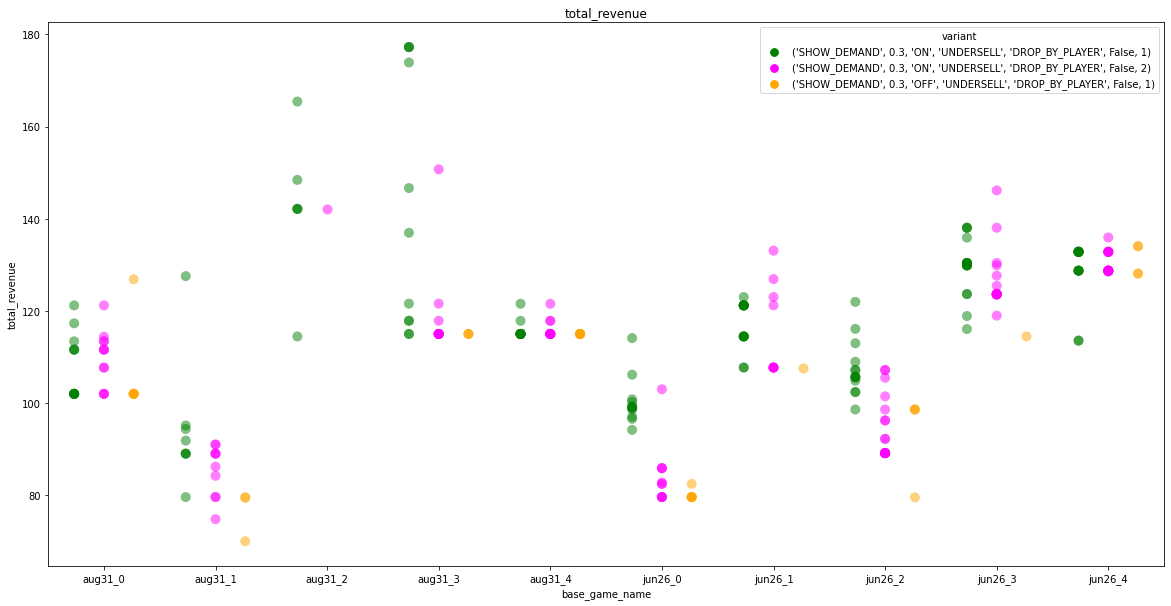

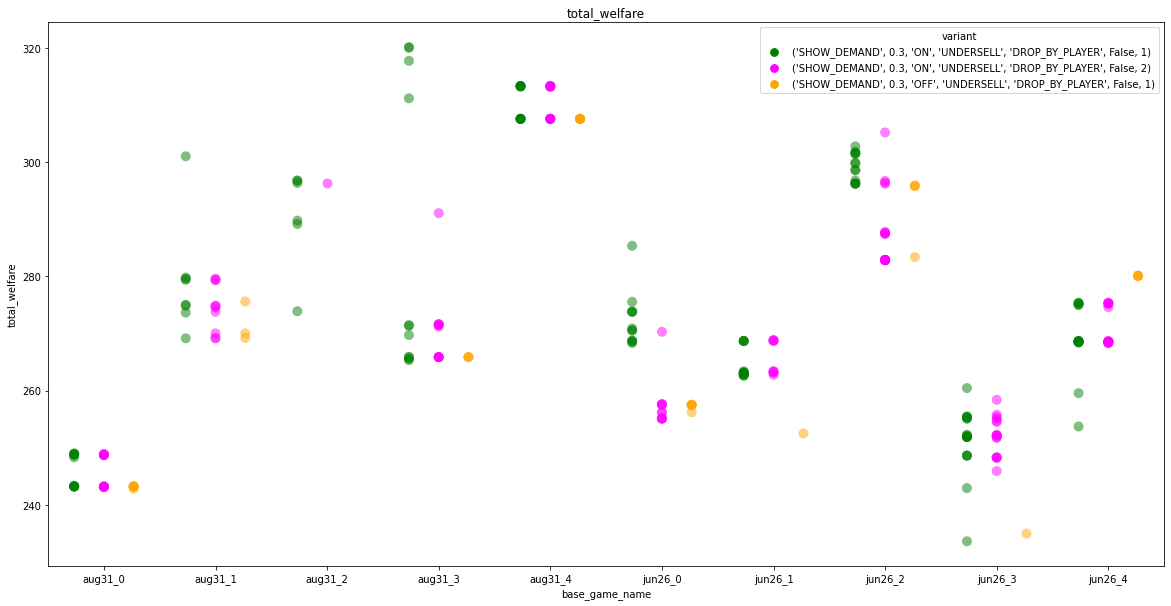

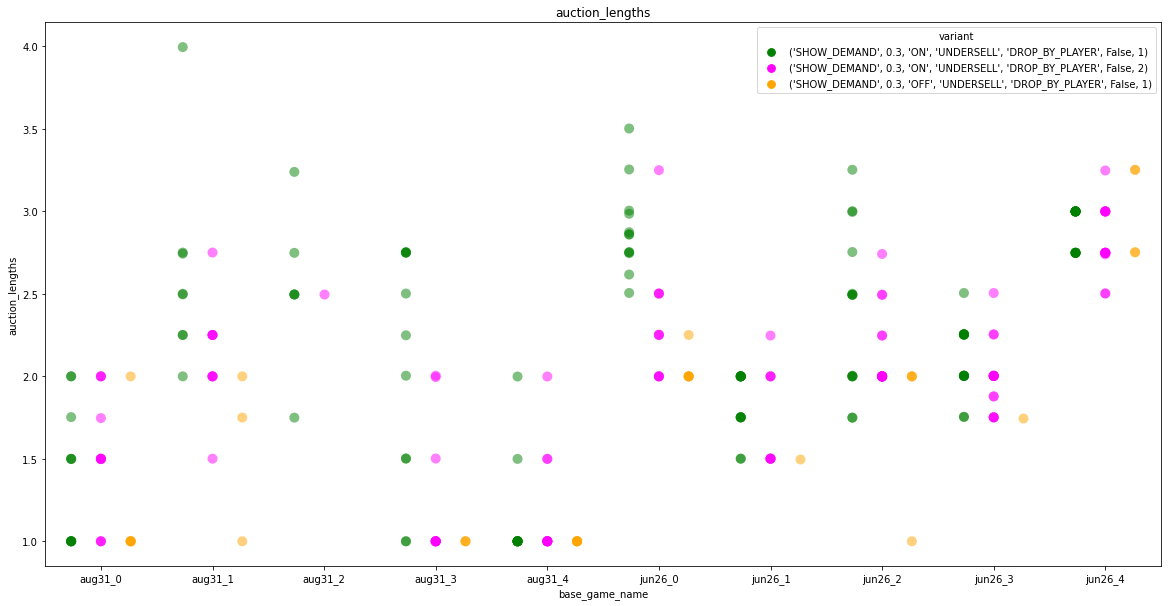

In [61]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# TODO: These strings are getting unwieldy

# Vanilla for clock
CLOCK_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1 and tiebreaking_policy == "DROP_BY_PLAYER"'
# box_df = box_df.query(CLOCK_QUERY)

# # Check undersell
UNDERSELL_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(UNDERSELL_QUERY)

# # Check activity
ACTIVITY_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(ACACTIVITY_QUERY)

# # Check tiebreaking
TIEBREAKING_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and grace_rounds == 1'
# box_df = box_df.query(TIEBREAKING_QUERY)

# Check grace
GRACE_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion'
# box_df = box_df.query(GRACE_QUERY)

# Activity ON vs grace vs activity OFF
box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion')


box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

# box_df = box_df.query('alg.str.contains("outcome")')

print(len(box_df))


STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df, **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     # TODO: If no entries exist, this pushes colours to the wrong positions
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [64]:
df_plt['rule_set'].value_counts()

def rule_set_to_value_structure(s):
    if 'spite' in s:
        return 'spite'
    elif 'risk_averse' in s:
        return 'risk_averse'
    else:
        return 'quasi_linear'

def rule_set_to_rule(s):
    if 'high_speed' in s:
        return 'high_speed'
    elif 'medium_speed' in s:
        return 'medium_speed'
    elif 'grace' in s:
        return 'grace'
    elif 'tie_break' in s:
        return 'tie_break'
    elif 'undersell_allowed' in s:
        return 'undersell_allowed'
    elif 'hide_demand' in s:
        return 'hide_demand'
    elif 'no_activity' in s:
        return 'no_activity'
    else:
        return 'base'
    
    
df_plt['value_structure'] = df_plt['rule_set'].apply(rule_set_to_value_structure)
df_plt['rule'] = df_plt['rule_set'].apply(rule_set_to_rule)

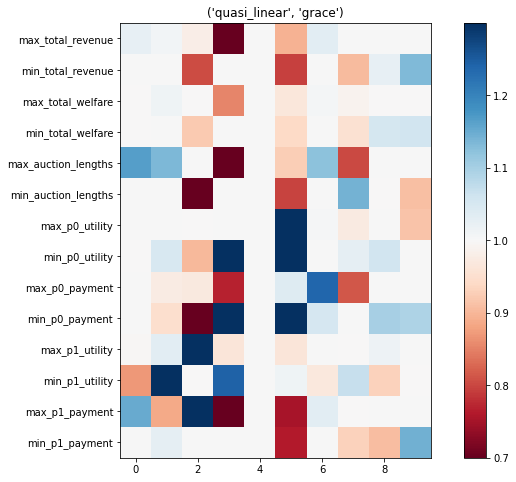

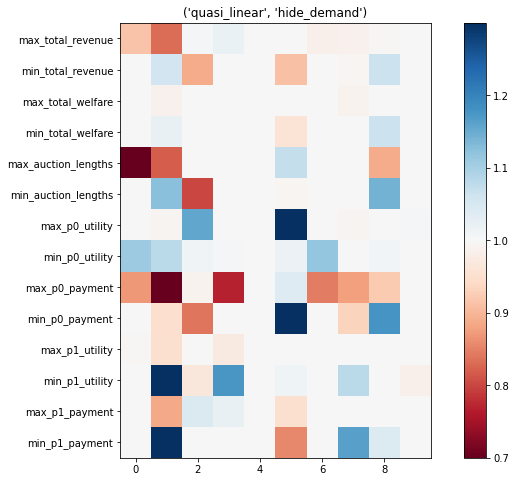

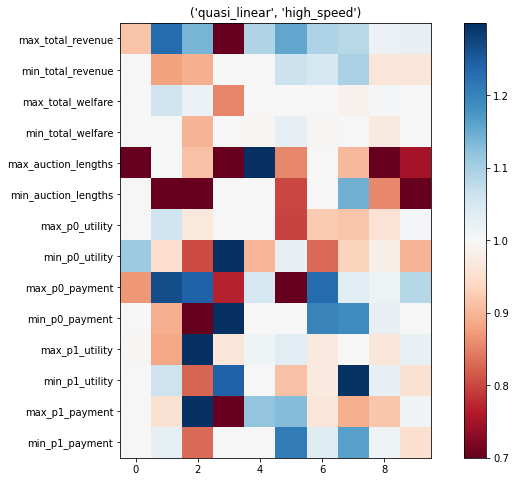

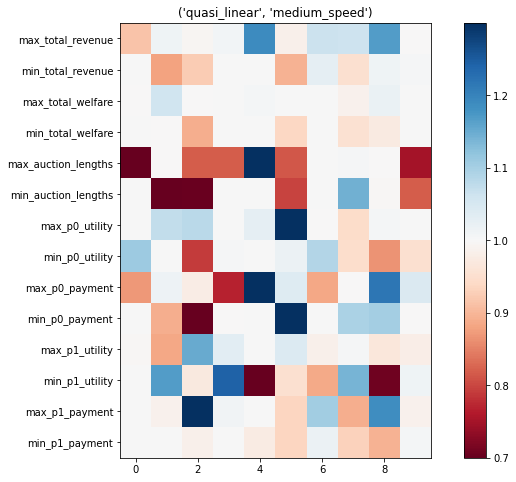

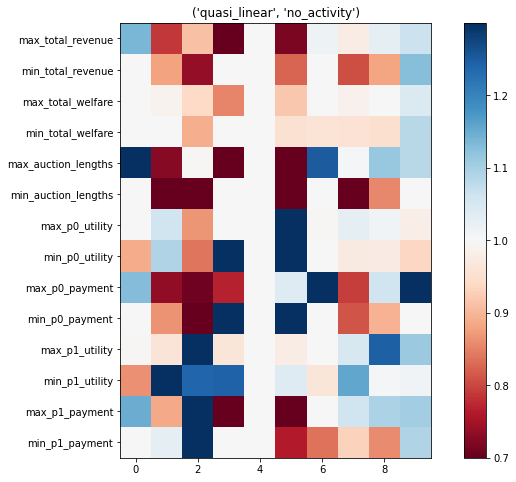

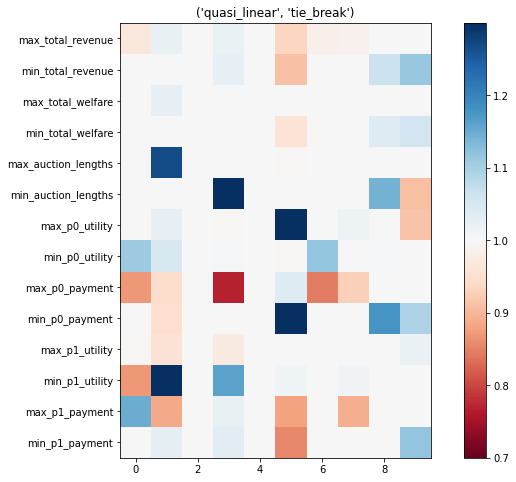

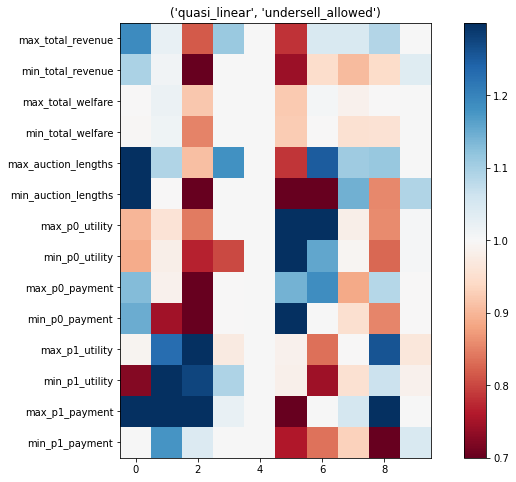

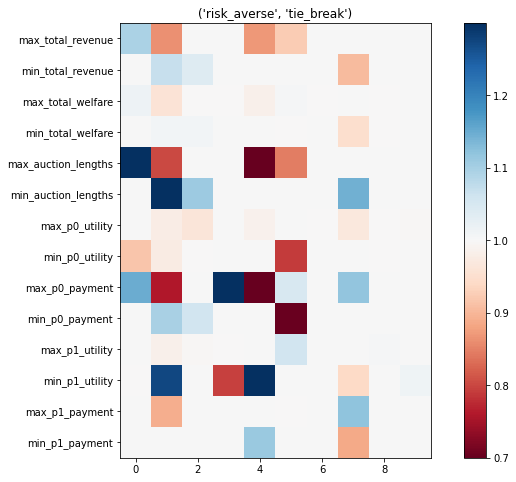

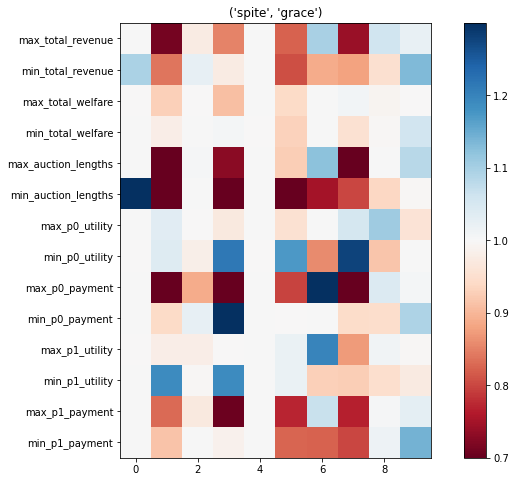

In [81]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule']):
    if idx[1] == 'base':
        continue
        
    data_grp_df = make_data_dict(grp_df)
    normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
    data_normalized_df = make_data_dict(normalizer_grp_df)
    
    cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.3)
    cmap = plt.cm.get_cmap('RdBu').copy()
    cmap.set_bad('magenta')
    plt.figure(figsize=(12, 8))
    data = (data_grp_df / data_normalized_df).values.T
    plt.imshow(data, cmap=cmap, norm=cmap_norm)
    plt.title(idx)
    plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
    plt.colorbar()
    plt.show()

    
# for query in [CLOCK_QUERY, UNDERSELL_QUERY, ACTIVITY_QUERY, TIEBREAKING_QUERY, GRACE_QUERY]: 
#     clock_df = df_plt.query(query)
#     data = dict()
#     for metric in metrics:
#         data[f'max_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].max()
#         data[f'min_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].min()

#     heatmap_df = pd.DataFrame(data) 
    


In [ ]:
heatmap_df.reset_index()['rule_set'].unique()

In [ ]:
df.query('run_name.str.contains("jun26_jun26_4_grace_period-cfr_port_2external_plus-100")')['nash_conv']

In [ ]:
df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3')[['nash_conv_frac']]

In [ ]:


# ### Code to rerun evals for a failed experiment
# from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
# exp = 'jun5outcome'

# for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp):
#     experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
#     run_name = e.checkpoint.equilibrium_solver_run.name
#     t = e.checkpoint.t
#     dispatch_eval_database(experiment_name, run_name, t, None, None)
# print(Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp).delete())

In [ ]:
df.query('alg == "PPO"').groupby(['experiment', 'imperfect']).mean()

In [ ]:
# val_df.groupby(['game', 'alg']).describe()
val_df.groupby(['game', 'alg']).describe()

In [ ]:
# import open_spiel.python.examples.ubc_dispatch as dispatch
# for run in runs:
#     try:
#         game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
#     except:
#         print("Skipping", run)
#         continue
#     final_checkpoint.bestresponse_set.all().delete()
#     for player in range(game.num_players()):
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'modal') 
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'tremble')  

In [ ]:
### This is the cell you run when you want to rerun evals 
bad_count = 0
overwrite_existing = True
for run in tqdm(runs):
    # print(run)
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue

    try:
        ev = final_checkpoint.get_modal_eval()
        if not pd.isnull(ev.nash_conv) and not overwrite_existing:
            continue
        else:
            ev.delete()
    except Exception as e:
        ev = None

    bad_count += 1
    br_mapping = {p: 'modal' for p in range(2)}
    dispatch.dispatch_eval_database(final_checkpoint.t, run.experiment.name, run.name, str(br_mapping))
    
print(bad_count)

In [107]:
### Reproduce hide demand error

game = pyspiel.load_game('python_clock_auction', dict(filename='aug31/aug31_1_hide_demand.json'))
run = EquilibriumSolverRun.objects.get(name='aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-101')
checkpoint = run.equilibriumsolverruncheckpoint_set.last()
env_and_policy = ppo_db_checkpoint_loader(checkpoint)

for i in range(2):
    env_and_policy.agents[i] = ModalAgentDecorator(env_and_policy.agents[i])
print("Starting")
nash_conv(game, env_and_policy.make_policy(), return_only_nash_conv=False, restrict_to_heuristics=True)


Starting
[0, 2]
[0, 2]
[0, 2]


_NashConvReturn(nash_conv=6.089289116705288, player_improvements=array([6.08928912, 0.        ]), br_policies=[<open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7f81de3268e0>, <open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7f81de326310>])

In [85]:
z[z > 2]

2    3
dtype: int64